# Acoustic feature extraction

Pykanto is designed to provide a platform that enables researchers to run and
any analyses that they might need with ease and in a reproducible way. The
precise nature of those analyses will vary greatly, so `pykanto`'s aim is not
to provide functions or methods to, for example, extract audio features—there
already are other, much better libraries for that.

These are some examples that show one way in which you can
extract and store features from vocalisations in a dataset created with pykanto:

In [1]:
from __future__ import annotations

from pathlib import Path

import pkg_resources

from pykanto.dataset import KantoData
from pykanto.parameters import Parameters
from pykanto.signal.analysis import (
    approximate_minmax_frequency,
    spec_centroid_bandwidth,
)
from pykanto.signal.segment import segment_files_parallel, ReadWav
from pykanto.utils.custom import (
    chipper_units_to_json,
    parse_sonic_visualiser_xml,
)
from pykanto.utils.io import get_unit_spectrograms, load_dataset
from pykanto.utils.paths import ProjDirs, get_file_paths, get_wavs_w_annotation
from pykanto.signal.spectrogram import retrieve_spectrogram


In [2]:
# ──── SETTINGS ────────────────────────────────────────────────────────────────

DATASET_ID = "STORM-PETREL"
DATA_PATH = Path(pkg_resources.resource_filename("pykanto", "data"))
PROJECT = Path(DATA_PATH).parent
RAW_DATA = DATA_PATH / "raw" / DATASET_ID
DIRS = ProjDirs(PROJECT, RAW_DATA, DATASET_ID, mkdir=True)

In [8]:
# ──── MAIN ────────────────────────────────────────────────────────────────────
# Creates and segments a dataset from raw data

wav_filepaths, xml_filepaths = [
    get_file_paths(DIRS.RAW_DATA, [ext]) for ext in [".wav", ".xml"]
]
files_to_segment = get_wavs_w_annotation(wav_filepaths, xml_filepaths)

segment_files_parallel(
    files_to_segment,
    DIRS,
    resample=22050,
    parser_func=parse_sonic_visualiser_xml,
    min_duration=0.1,
    min_freqrange=100,
    labels_to_ignore=["NOISE"],
    verbose=False
)

chipper_units_to_json(DIRS.SEGMENTED, overwrite_json = True)

params = Parameters(
    window_length=512,
    hop_length=32,
    n_fft=2048,
    num_mel_bins=240,
    sr=22050,
    top_dB=65,
    highcut=10000,
    lowcut=0,
    dereverb=False,
    verbose=False,
)
dataset = KantoData(
    DIRS,
    parameters=params,
    overwrite_dataset=True,
    overwrite_data=False,
)

out_dir = DIRS.DATA / "datasets" / DATASET_ID / f"{DATASET_ID}.db"
dataset = load_dataset(out_dir, DIRS)
dataset.segment_into_units()

Found 2 files. They will be processed in 2 chunks of length 1.


Finding and saving audio segments and their metadata:   0%|          | 0/2 [00:00<?, ?it/s]

Function 'segment_files_parallel' took 18.2710 sec.


Adding unit onset/offset information from .gzip to .json files:   0%|          | 0/11 [00:00<?, ?it/s]

Function 'chipper_units_to_json' took 63.7345 sec.


Loading JSON files:   0%|          | 0/22 [00:00<?, ?it/s]

KeyError: 'wav_file'

We now have a dataset that contains multiple vocalisations. Let's tell `pykanto`
that we want to look at individual notes, by setting `song_level=False`, and
then plot the spectrogram for a single vocalisation in the dataset.

Calculating and saving unit spectrograms:   0%|          | 0/1 [00:00<?, ?it/s]

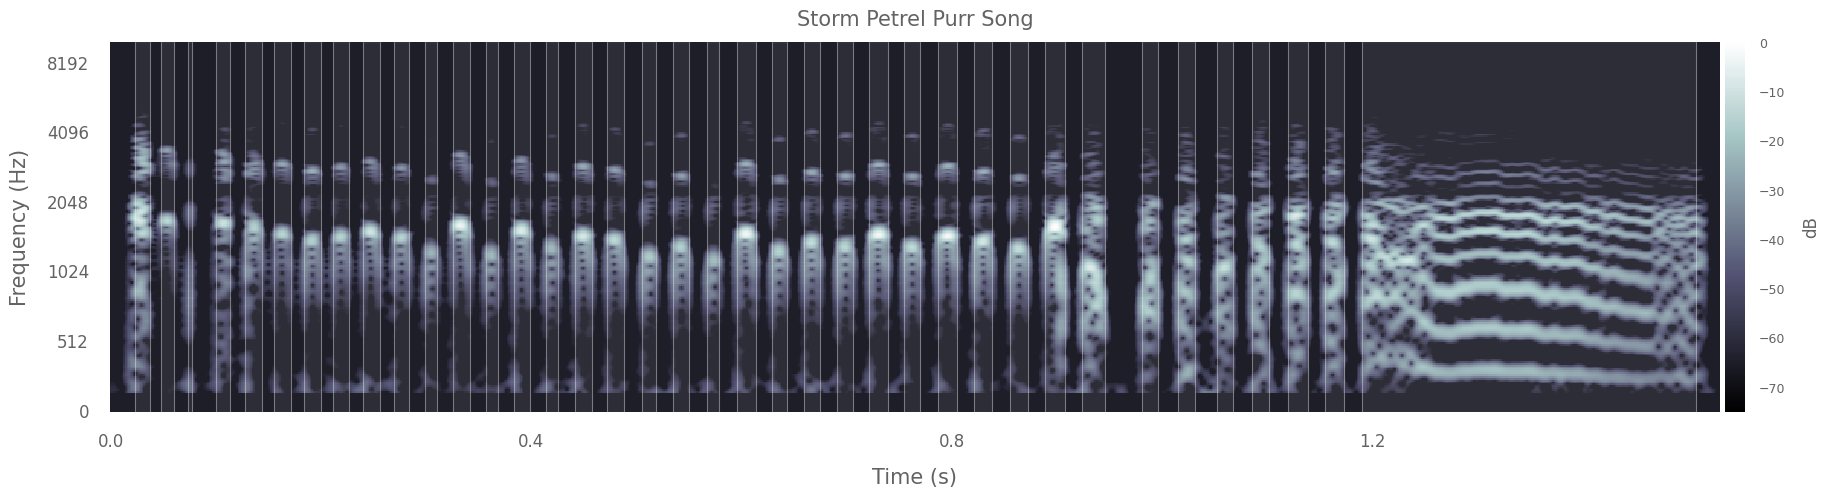

In [4]:
# Tell pykanto to run the analysis at the unit, not song, level
dataset.parameters.update(song_level=False)
dataset.get_units()

# Choose a song to look at
ID = "STORM-PETREL"
key = str(dataset.data.index[9])

# Plot spectrogram of vocalisation, with note on/offsets
dataset.plot(key, title= 'Storm Petrel Purr Song', segmented=True)

Now that the data are ready, we can extract some features from the spectrograms.
As an example, let's estimate the minimum and maximum frequencies and the
spectral centroid of each note over time using pykanto, and plot the results.

Here I have selected the final note of a male Storm Petrel's 'purring song':

>
> The purring sound is given in short bursts, separated by a strange little
> breath note, once famously likened to “a fairy being sick” (C Oldham in
> Lockley 1983). Purring is more often heard coming from the safety of a burrow,
> where the combined phrase of purring plus breath note is repeated
> monotonously, often for minutes on end. <div style="text-align: right">
> [Magnus Robb / The Sound
> Approach](https://soundapproach.co.uk/species/british-storm-petrel/) </div>
> 


In [ ]:
%%capture

# Extract spectrograms of units and get the last note of the song
units = get_unit_spectrograms(dataset, ID)
breath_note = units[key][-1]

# This returns arrays of floats with a time series of min and max frequencies
minfreqs, maxfreqs = approximate_minmax_frequency(
    dataset, spec=breath_note, plot=True, roll_percents=[0.9, 0.05]
)

# This returns a time series of spectral centroids and badwidths
centroid, bw = spec_centroid_bandwidth(dataset, spec=breath_note, plot=True)

![output](../custom/freq_bw_fig.jpg)

In [12]:
from pykanto.signal.segment import ReadWav
from pykanto.signal.spectrogram import retrieve_spectrogram
key = dataset.data.index[0]

spec = retrieve_spectrogram(dataset.files.at[key, "spectrogram"])
wav_object = ReadWav(Path(dataset.files.at[key, "wav_file"]))
wavfile, audio_metadata = wav_object.get_wav(), wav_object.as_dict()

That's just an example using wrappers around a couple of
`[librosa](https://librosa.org/doc/latest/index.html)` functions. In general, if
you need to access a spectrogram for further analysis, you can do so easily by
calling

```{code-block} python
spec = retrieve_spectrogram(dataset.files.at[key, "spectrogram"])
```

where `key` is the index of the vocalisation you want to access. If you need to
access the audio file itself, you can do it like so:

```{code-block} python
wav_object = ReadWav(Path(dataset.files.at[key, "wav_file"]))
wavfile, audio_metadata = wav_object.get_wav(), wav_object.as_dict()
```

or using your favourite library that can read wav files.